In [8]:
# classification mlp model for the abalone dataset
import numpy as np
import pandas as pd
#from pandas import read_csv
import tensorflow as tf
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense
import sklearn as skl
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import os
import statistics
from sklearn.metrics import auc
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import seaborn as sns
from matplotlib import pyplot as plt
import shap
# load dataset
os.chdir("/home/smha118/data1/ibd/prediction_datasets/3_future_response/")


In [15]:
import scipy as sci
import matplotlib as plt
print(np.__version__)
print(pd.__version__)
print(tf.__version__)
print(skl.__version__)
print(sci.__version__)
print(plt.__version__)
print(sns.__version__)
print(shap.__version__)

1.20.3
1.4.2
2.7.0
1.1.1
1.8.1
3.4.3
0.11.2
0.39.0


In [2]:
def pointbiserialFilter(X,y):
    corr_list = []
    p_val_list=[]
    for i in range(len(X.columns)):
        cor=stats.pointbiserialr(X.iloc[:,i], y)
        corr_list.append(cor[0])
        p_val_list.append(cor[1])
    cor_df=pd.DataFrame({"cor":corr_list,"pval":p_val_list})
    index=((cor_df.iloc[:,0]>0.1) | (cor_df.iloc[:,0]< -0.1)) & (cor_df.iloc[:,1]<0.05) 
    X_transpose=X.T
    X=X_transpose[index.set_axis(X_transpose.index)].T
    return X

In [3]:
def model_train_roc(X,y,file,result_table):
    kfold = KFold(n_splits=10, shuffle=True)
    # K-fold Cross Validation model evaluation
    fold_no = 1
    units=25
    acc_=list()
    fpr_=list()
    fnr_=list()
    tpr_=list()
    tnr_=list()
    auc_=list()
    for train, test in kfold.split(X, y):
        X_train=X.iloc[train]
        X_test=X.iloc[test]
        y_train=y[train]
        y_test=y[test]
        n_features = X_train.shape[1]
        n_class = len(np.unique(y_train))
        model = Sequential()
        model.add(Dense(units, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))
        # The Hidden Layers :
        model.add(Dense(units, kernel_initializer='normal',activation='relu'))
        model.add(Dense(units, kernel_initializer='normal',activation='relu'))
        model.add(Dense(units, kernel_initializer='normal',activation='relu'))
        model.add(Dense(units, kernel_initializer='normal',activation='relu'))
        model.add(Dense(units, kernel_initializer='normal',activation='relu'))
        model.add(Dense(n_class, activation='sigmoid'))
        # compile the keras model
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
        # fit the keras model on the dataset
        history = model.fit(X_train, y_train, epochs=150, batch_size=32, verbose=0)
        # evaluate on test set
        y_pred_keras = model.predict(X_test)
        y_pred_keras = np.argmax(y_pred_keras, axis=-1).astype('int')
        acc = accuracy_score(y_test, y_pred_keras)
        fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
        fnr=1-tpr_keras
        tnr=1-fpr_keras
        fnr_.append(fnr)
        tnr_.append(tnr)
        fpr_.append(fpr_keras)
        tpr_.append(tpr_keras)

        acc_.append(acc)
        print(fold_no)

        # Increase fold number
        fold_no = fold_no + 1


    mean_tpr = np.mean(tpr_, axis=0)
    mean_fpr = np.mean(fpr_, axis=0)
    new_tpr=list()
    new_tnr=list()
    new_fpr=list()
    new_fnr=list()
    for i in range(len(tpr_)):
        new_tpr.append(tpr_[i][1])
    for i in range(len(tnr_)):
        new_tnr.append(tnr_[i][1])
    for i in range(len(fpr_)):
        new_tnr.append(fpr_[i][1])
    for i in range(len(fpr_)):
        new_fnr.append(fnr_[i][1])
    auc_keras = auc(mean_fpr, mean_tpr)
    result_table = result_table.append({'file':file,
                                            'auc':auc_keras,
                                            'acc':acc_,
                                            'mean_fpr':mean_fpr,
                                            'mean_tpr':mean_tpr,
                                            'tpr':new_tpr,
                                            'tnr':new_tnr,
                                            'fpr':new_fpr,
                                            'fnr':new_fnr
                                             }, ignore_index=True)
    return (result_table)

range(1, 4)

In [4]:
dataframe = read_csv("future_responder.sample_class.tsv",sep="\t", header=0)
dataset = dataframe.values
y=dataframe["future.response"]
y = LabelEncoder().fit_transform(y)

In [43]:
X=read_csv("future_responder.bacteria_genus.tsv",sep="\t",header=0,index_col=0)
X=np.log(X+1)
X=pointbiserialFilter(X,y)
result_table = pd.DataFrame(columns=['file','auc','acc', 'mean_fpr','mean_tpr','tpr','tnr','fpr','fnr'])
result_table=model_train_roc(X,y,"Genus",result_table)

1
2
3
4
5
6
7
8
9
10


/tmp/ipykernel_7938/950569601.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_table = result_table.append({'file':file,


In [5]:
X=read_csv("future_responder.bacteria_ASV.tsv",sep="\t",header=0,index_col=0)
X=np.log(X+1)
X=pointbiserialFilter(X,y)
#result_table=model_train_roc(X,y,"ASV",result_table)

In [506]:
with open("selected.asv.txt","w")as f:
    f.write("\n".join(list(X.columns)))



In [45]:
X=read_csv("future_responder.bacteria_OTU.tsv",sep="\t",header=0,index_col=0)
X=np.log(X+1)
X=pointbiserialFilter(X,y)
result_table=model_train_roc(X,y,"OTU",result_table)

1
2
3
4
5
6
7
8
9
10


/tmp/ipykernel_7938/950569601.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_table = result_table.append({'file':file,


In [22]:
type(result_table)

pandas.core.frame.DataFrame

In [46]:
# result_table=result_table.set_index("file")
result_table

,file,auc,acc,mean_fpr,mean_tpr,tpr,tnr,fpr,fnr
0,Genus,0.600533,"[0.6666666666666666, 0.48148148148148145, 0.70...","[0.0, 0.4799621212121211, 1.0]","[0.0, 0.681027926322044, 1.0]","[0.6666666666666666, 0.5294117647058824, 0.727...","[0.6666666666666667, 0.4, 0.6875, 0.5, 0.53333...",[],"[0.33333333333333337, 0.47058823529411764, 0.2..."
1,ASV,0.791618,"[0.7777777777777778, 0.7777777777777778, 0.777...","[0.0, 0.22217171717171716, 1.0]","[0.0, 0.8054084967320261, 1.0]","[0.8, 0.8125, 0.8888888888888888, 0.8888888888...","[0.75, 0.7272727272727273, 0.5555555555555556,...",[],"[0.19999999999999996, 0.1875, 0.11111111111111..."
2,OTU,0.690977,"[0.8148148148148148, 0.6666666666666666, 0.703...","[0.0, 0.3350613275613275, 1.0]","[0.0, 0.7170156584901167, 1.0]","[1.0, 0.7333333333333333, 0.7368421052631579, ...","[0.5454545454545454, 0.5833333333333333, 0.625...",[],"[0.0, 0.2666666666666667, 0.26315789473684215,..."


In [23]:
result_table.reset_index()

,file,auc,acc,mean_fpr,mean_tpr,tpr,tnr,fpr,fnr
0,Genus,0.57722,"[0.5925925925925926, 0.48148148148148145, 0.55...","[0.0, 0.5002240814740814, 1.0]","[0.0, 0.6546645090375741, 1.0]","[[0.0, 0.6363636363636364, 1.0], [0.0, 0.66666...","[[1.0, 0.5625, 0.0], [1.0, 0.11111111111111116...","[[0.0, 0.4375, 1.0], [0.0, 0.8888888888888888,...","[[1.0, 0.36363636363636365, 0.0], [1.0, 0.3333..."
1,ASV,0.780366,"[0.8888888888888888, 0.7037037037037037, 0.814...","[0.0, 0.23658119658119658, 1.0]","[0.0, 0.797313079077785, 1.0]","[[0.0, 0.9333333333333333, 1.0], [0.0, 0.66666...","[[1.0, 0.8333333333333334, 0.0], [1.0, 0.77777...","[[0.0, 0.16666666666666666, 1.0], [0.0, 0.2222...","[[1.0, 0.06666666666666665, 0.0], [1.0, 0.3333..."
2,OTU,0.728158,"[0.7037037037037037, 0.8518518518518519, 0.629...","[0.0, 0.3117965367965368, 1.0]","[0.0, 0.7681134822349992, 1.0]","[[0.0, 0.6666666666666666, 1.0], [0.0, 0.82352...","[[1.0, 0.7333333333333334, 0.0], [1.0, 0.9, 0....","[[0.0, 0.26666666666666666, 1.0], [0.0, 0.1, 1...","[[1.0, 0.33333333333333337, 0.0], [1.0, 0.1764..."


In [138]:
df = pd.melt(result_table.reset_index(),id_vars='file',value_vars=result_table.columns)
df

,file,variable,value
0,Genus,auc,0.600533
1,ASV,auc,0.791618
2,OTU,auc,0.690977
3,Genus,acc,"[0.6666666666666666, 0.48148148148148145, 0.70..."
4,ASV,acc,"[0.7777777777777778, 0.7777777777777778, 0.777..."
5,OTU,acc,"[0.8148148148148148, 0.6666666666666666, 0.703..."
6,Genus,mean_fpr,"[0.0, 0.4799621212121211, 1.0]"
7,ASV,mean_fpr,"[0.0, 0.22217171717171716, 1.0]"
8,OTU,mean_fpr,"[0.0, 0.3350613275613275, 1.0]"
9,Genus,mean_tpr,"[0.0, 0.681027926322044, 1.0]"


In [141]:
df_tpr=df[df["variable"]=='tpr']
df_tnr=df[df["variable"]=='tnr']
df_acc=df[df["variable"]=='acc']

In [144]:
df_sensitivity=pd.DataFrame(columns=['type','variable','value'])
df_specificity=pd.DataFrame(columns=['type','variable','value'])
df_accuracy=pd.DataFrame(columns=['type','variable','value'])

In [91]:
type_="OTU"
variable="tpr"
for i in list(df_tpr[df_tpr['file']==type_]['value'])[0]:
    df_sensitivity.loc[len(df_sensitivity.index)] = [type_, variable, i] 


In [150]:
type_="ASV"
variable="tnr"
for i in list(df_tnr[df_tnr['file']==type_]['value'])[0]:
    df_specificity.loc[len(df_specificity.index)] = [type_, variable, i] 
type_="OTU"
variable="tnr"
for i in list(df_tnr[df_tnr['file']==type_]['value'])[0]:
    df_specificity.loc[len(df_specificity.index)] = [type_, variable, i] 
type_="Genus"
variable="tnr"
for i in list(df_tnr[df_tnr['file']==type_]['value'])[0]:
    df_specificity.loc[len(df_specificity.index)] = [type_, variable, i] 

In [152]:
type_="ASV"
variable="acc"
for i in list(df_acc[df_acc['file']==type_]['value'])[0]:
    df_accuracy.loc[len(df_accuracy.index)] = [type_, variable, i] 
type_="OTU"
variable="acc"
for i in list(df_acc[df_acc['file']==type_]['value'])[0]:
    df_accuracy.loc[len(df_accuracy.index)] = [type_, variable, i] 
type_="Genus"
variable="acc"
for i in list(df_acc[df_acc['file']==type_]['value'])[0]:
    df_accuracy.loc[len(df_accuracy.index)] = [type_, variable, i] 

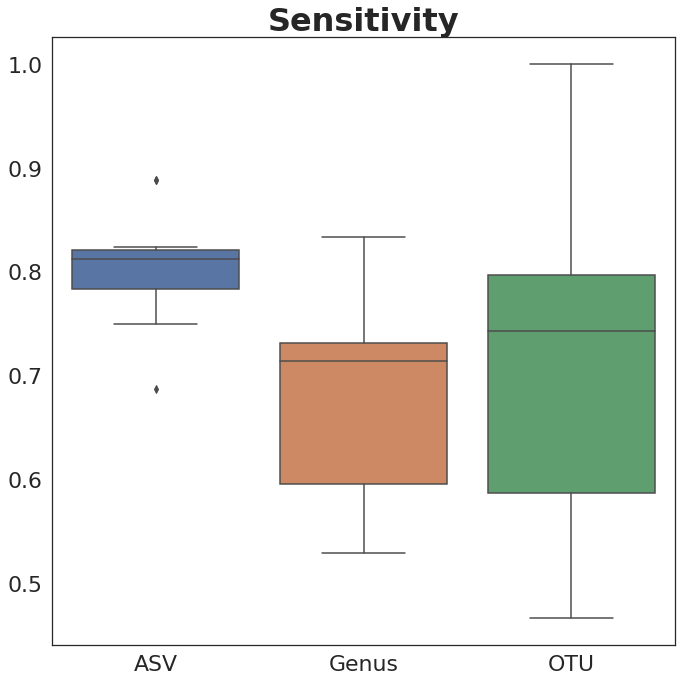

In [137]:
plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["figure.autolayout"] = True
#sns.set(rc={'figure.figsize':(10,10)})
#sns.set_theme(style='white')
#sns.set_style("white")

sns.set_theme(style="white",font_scale=2)
#sns.set(font_scale=2)
g=sns.boxplot(data=df_sensitivity, x="type", y="value", hue="type", dodge=False)
g.set_title('Sensitivity',fontdict= { 'fontsize': 32, 'fontweight':'bold'})
g.legend_.remove()
g.set(xlabel=None,ylabel=None)


plt.show()


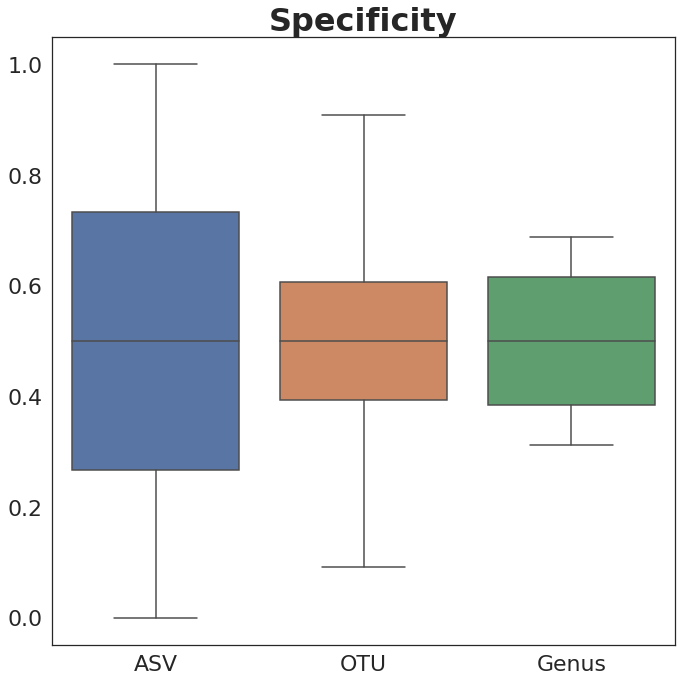

In [153]:
plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["figure.autolayout"] = True
#sns.set(rc={'figure.figsize':(10,10)})
#sns.set_theme(style='white')
#sns.set_style("white")

sns.set_theme(style="white",font_scale=2)
#sns.set(font_scale=2)
g=sns.boxplot(data=df_specificity, x="type", y="value", hue="type", dodge=False)
g.set_title('Specificity',fontdict= { 'fontsize': 32, 'fontweight':'bold'})
g.legend_.remove()
g.set(xlabel=None,ylabel=None)


plt.show()


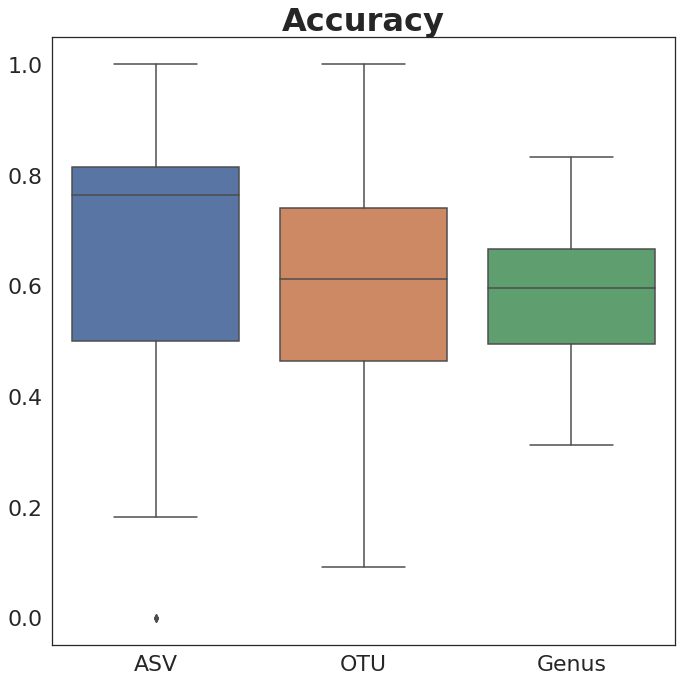

In [154]:
plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["figure.autolayout"] = True
#sns.set(rc={'figure.figsize':(10,10)})
#sns.set_theme(style='white')
#sns.set_style("white")

sns.set_theme(style="white",font_scale=2)
#sns.set(font_scale=2)
g=sns.boxplot(data=df_accuracy, x="type", y="value", hue="type", dodge=False)
g.set_title('Accuracy',fontdict= { 'fontsize': 32, 'fontweight':'bold'})
g.legend_.remove()
g.set(xlabel=None,ylabel=None)


plt.show()


Genus
ASV
OTU


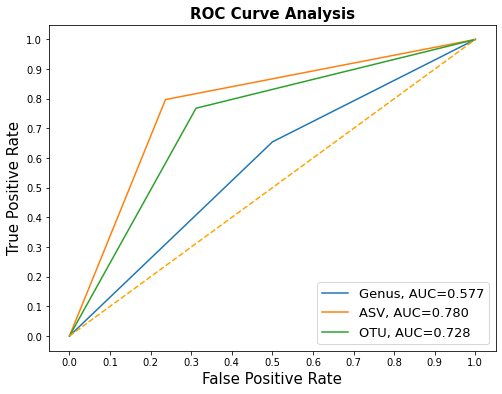

In [16]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    print(i)
    plt.plot(result_table.loc[i]['mean_fpr'], 
             result_table.loc[i]['mean_tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')


plt.show()

Genus
ASV
OTU


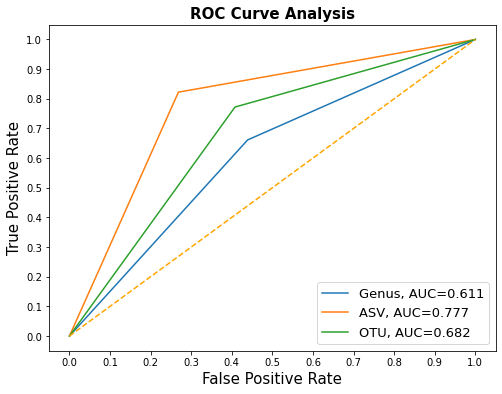

In [499]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    print(i)
    plt.plot(result_table.loc[i]['mean_fpr'], 
             result_table.loc[i]['mean_tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')


plt.show()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


In [9]:
units=25
n_features = X_train.shape[1]
n_class = len(np.unique(y_train))
model = Sequential()
model.add(Dense(units, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))
# The Hidden Layers :
model.add(Dense(units, kernel_initializer='normal',activation='relu'))
model.add(Dense(units, kernel_initializer='normal',activation='relu'))
model.add(Dense(units, kernel_initializer='normal',activation='relu'))
model.add(Dense(units, kernel_initializer='normal',activation='relu'))
model.add(Dense(units, kernel_initializer='normal',activation='relu'))
model.add(Dense(n_class, activation='sigmoid'))
# compile the keras model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
# fit the keras model on the dataset
history = model.fit(X_train, y_train, epochs=150, batch_size=32, verbose=0)

2022-11-30 16:56:30.066644: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
def f(X):
    return np.argmax(model.predict(X), axis=-1).astype('int')
    #return model.predict([X[:,i] for i in range(X.shape[1])]).flatten()

In [11]:
import shap 
explainer = shap.KernelExplainer(f, X_train)
#shap_values = shap.Explainer(history).shap_values(X_train)

Using 187 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [12]:
shap_values=explainer.shap_values(X_test, nsamples=500)

  0%|          | 0/81 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

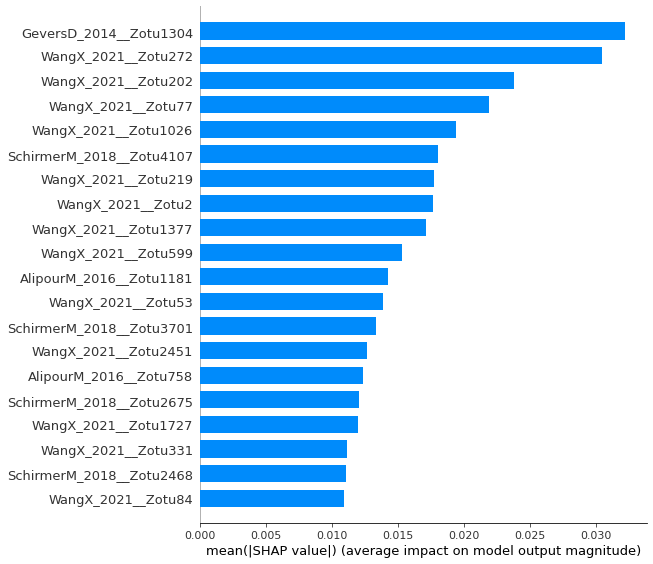

In [18]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [19]:
shap_values

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.00483665,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.00490351,
         0.        ,  0.        ],
       [ 0.00755127,  0.04068649,  0.        , ...,  0.        ,
         0.05125732,  0.        ],
       ...,
       [ 0.        , -0.01402834,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.02157169,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [34]:
len(model.predict(X_train).flatten())

374

In [40]:
np.argmax(model.predict(X_train), axis=-1).astype('int')

array([1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0])